In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import extract_correct_csv

## All valid subject

In [2]:
valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_subject

[2, 4, 10, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

In [3]:
columns = list(pd.read_csv('../osf-storage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_

In [4]:
generic_df = pd.DataFrame(columns=columns)
for x in valid_subject:
    cur_sub = extract_correct_csv.read_correct_subject_csv(x)
    subject = pd.read_csv('data/LookAtMe_0'+cur_sub+'.csv', sep='\t')
    pupil_subj = pd.read_csv('../osf-storage-archive/eye/pupil/Look0'+cur_sub+'_pupil.csv', sep=';', decimal=',')
    expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
    df_ = pupil_subj.copy(deep=False)
    df_['expectancy'] = expectancy
    df_['shock'] = subject['shock']
    generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])

/tmp/ipykernel_24646/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_24646/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_24646/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_24646/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype inste

In [5]:
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]

In [6]:
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
mean_baseline

2.3951070719941048

In [9]:
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)-mean_baseline
all_conf_1 = df_LE_shock.var(axis=0)/np.sqrt(len(X))

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)-mean_baseline
all_conf_2 = df_LE_no_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)-mean_baseline
all_conf_3 = df_HE_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)-mean_baseline
all_conf_4 = df_HE_no_shock.std(axis=0)/np.sqrt(len(X))


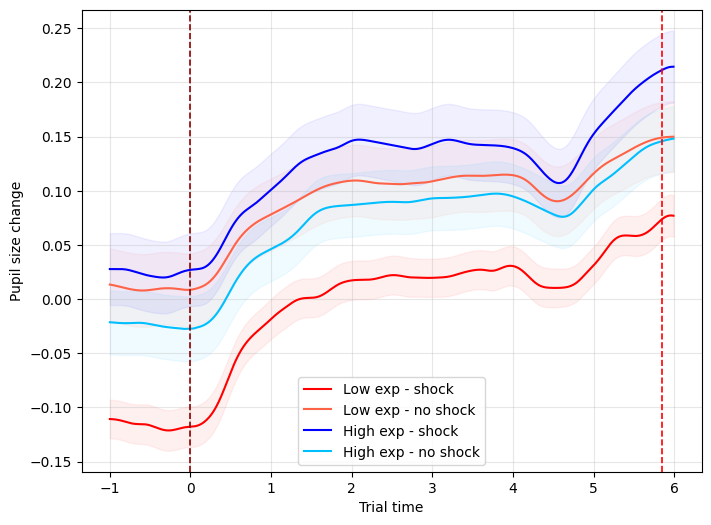

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color = 'r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color = 'tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color = 'b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color = 'deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()